# Cart-pole Balancing Model with Amazon SageMaker and Ray

---
## Introduction

In this notebook we'll start from the cart-pole balancing problem, where a pole is attached by an un-actuated joint to a cart, moving along a frictionless track. Instead of applying control theory to solve the problem, this example shows how to solve the problem with reinforcement learning on Amazon SageMaker and Ray RLlib. You can choose either TensorFlow or PyTorch as your underlying DL framework.

(For a similar example using Coach library, see this [link](../rl_cartpole_coach/rl_cartpole_coach_gymEnv.ipynb). Another Cart-pole example using Coach library and offline data can be found [here](../rl_cartpole_batch_coach/rl_cartpole_batch_coach.ipynb).)

1. *Objective*: Prevent the pole from falling over
2. *Environment*: The environment used in this exmaple is part of OpenAI Gym, corresponding to the version of the cart-pole problem described by Barto, Sutton, and Anderson [1]
3. *State*: Cart position, cart velocity, pole angle, pole velocity at tip	
4. *Action*: Push cart to the left, push cart to the right
5. *Reward*: Reward is 1 for every step taken, including the termination step

References

1. AG Barto, RS Sutton and CW Anderson, "Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem", IEEE Transactions on Systems, Man, and Cybernetics, 1983.

## Pre-requisites 

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [1]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
import numpy as np
from IPython.display import HTML
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

### Setup S3 bucket

Set up the linkage and authentication to the S3 bucket that you want to use for checkpoint and the metadata. 

In [2]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-west-2-775004277940/


### Define Variables 

We define variables such as the job prefix for the training jobs *and the image path for the container (only when this is BYOC).*

In [3]:
# create a descriptive job name 
job_name_prefix = 'rl-cartpole-ray'

### Configure where training happens

You can train your RL training jobs using the SageMaker notebook instance or local notebook instance. In both of these scenarios, you can run the following in either local or SageMaker modes. The local mode uses the SageMaker Python SDK to run your code in a local container before deploying to SageMaker. This can speed up iterative testing and debugging while using the same familiar Python SDK interface. You just need to set `local_mode = True`.

In [4]:
# run in local_mode on this machine, or as a SageMaker TrainingJob?
local_mode = False

if local_mode:
    instance_type = 'local'
else:
    # If on SageMaker, pick the instance type
    instance_type, CPU_OR_GPU = "ml.m5.4xlarge", "cpu"
    #instance_type = "ml.p3.2xlarge"

### Create an IAM role

Either get the execution role when running from a SageMaker notebook instance `role = sagemaker.get_execution_role()` or, when running from local notebook instance, use utils method `role = get_execution_role()` to create an execution role.

Make sure the IAM role has `AmazonEC2ContainerRegistryFullAccess` and `AmazonS3FullAccess`.

In [5]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::775004277940:role/service-role/AmazonSageMaker-ExecutionRole-20210324T111884


### Install docker for `local` mode

In order to work in `local` mode, you need to have docker installed. When running from you local machine, please make sure that you have docker and docker-compose (for local CPU machines) and nvidia-docker (for local GPU machines) installed. Alternatively, when running from a SageMaker notebook instance, you can simply run the following script to install dependenceis.

Note, you can only run a single local notebook at one time.

In [6]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./common/setup.sh

## Write the Training Code

The training code is written in the file “train-rl-cartpole-ray.py” which is uploaded in the /src directory. 
First import the environment files and the preset files, and then define the main() function. 

**Note**: If PyTorch is used, plese update the above training code and set `use_pytorch` to `True` in the config.

In [7]:
!pygmentize src/train-rl-cartpole-ray.py

import json
import os

import gym
import ray
from ray.tune import run_experiments
from ray.tune.registry import register_env

from sagemaker_rl.ray_launcher import SageMakerRayLauncher


def create_environment(env_config):
    return gym.make('CartPole-v1') #, render_mode="rgb_array")

class MyLauncher(SageMakerRayLauncher):

    def register_env_creator(self):
        register_env("CartPole-v1", create_environment)

    def get_experiment_config(self):
        return {
          "training": {
            "env": "CartPole-v1",
            "run": "PPO",
            #"checkpoint_freq": 1, # does not work for pyTorch
            "stop": {
                "training_iteration": 5
            },
            "config": {
              "framework": "torch", # "torch" or "tf"
              "gamma": 0.99,
              "kl_coeff": 1.0,
              "num_sgd_iter": 20,
              "lr": 0.0001,
              "sgd_minibatch_size": 1000,
              "train_batch_size": 25000, # (self.num_cpus-1

# Configure the framework you want to use

Set `framework` to `"tf"` or `"torch"` for tensorflow or pytorch respectively.

You will also have to edit your entry point i.e., [`train-sagemaker.py`](./source/train-sagemaker.py) with the configuration parameter `framework` to match the framework that you have selected.

In [8]:
framework = "torch"

## Build docker container

We must build a custom docker container with Roboschool installed.  This takes care of everything:

1. Fetching base container image
2. Installing Roboschool and its dependencies
3. Uploading the new container image to ECR

This step can take a long time if you are running on a machine with a slow internet connection.  If your notebook instance is in SageMaker or EC2 it should take 3-10 minutes depending on the instance type.


In [9]:
!docker stop $(docker ps -aq)
!docker rm $(docker ps -aq)
!docker rmi -f $(docker images -a -q)

"docker stop" requires at least 1 argument.
See 'docker stop --help'.

Usage:  docker stop [OPTIONS] CONTAINER [CONTAINER...]

Stop one or more running containers
"docker rm" requires at least 1 argument.
See 'docker rm --help'.

Usage:  docker rm [OPTIONS] CONTAINER [CONTAINER...]

Remove one or more containers
Untagged: 775004277940.dkr.ecr.us-west-2.amazonaws.com/ray-1_1_cartpole-cpu:latest
Untagged: 775004277940.dkr.ecr.us-west-2.amazonaws.com/ray-1_1_cartpole-cpu@sha256:61ca48f1384b0c1b1759eb323fce7646edbce2ecd152f890c01a68a8bd81a7be
Untagged: ray-1_1_cartpole-cpu:latest
Deleted: sha256:6e2b5e37b860b02c8412bf7a3fc9b7894951df874ce0184308ed4c57f740bd1c
Deleted: sha256:2a110167a9954e03ae5343f3f6f67723043afd3a2bfef1840118b69623232a3b
Deleted: sha256:1e1ea5f94e59106702f4214311fa07a5b4d1970081ada41a796a09f3dcdff46c
Deleted: sha256:1be0202c7474dd0505abd855d7fab840dc47c8e6226df13c9d70f6c9ae94361a
Deleted: sha256:375ff7c340414b4b096ee2c31b8ee6a7f31d2adfcebf083a7e67736bd8195465
Deleted: sha

In [10]:
if CPU_OR_GPU == "cpu":
    suffix = 'ubuntu18.04'
else:
    # tf2 'cu100-ubuntu18.04'
    # torch 'cu102-ubuntu18.04'
    suffix = 'cu102-ubuntu18.04'


aws_region = boto3.Session().region_name
    
repository_short_name = "ray-1_1_cartpole-{}".format(CPU_OR_GPU)

docker_build_args = {
    'processor': CPU_OR_GPU, 
    'region': aws_region,
    'suffix': suffix,
}
image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)


WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Logged into ECR
Building docker image ray-1_1_cartpole-cpu from Dockerfile
$ docker build -t ray-1_1_cartpole-cpu -f Dockerfile . --build-arg processor=cpu --build-arg region=us-west-2 --build-arg suffix=ubuntu18.04
Sending build context to Docker daemon  842.2kB
Step 1/23 : ARG processor
Step 2/23 : ARG region
Step 3/23 : ARG suffix
Step 4/23 : FROM 763104351884.dkr.ecr.$region.amazonaws.com/pytorch-training:1.7.1-$processor-py36-$suffix
1.7.1-cpu-py36-ubuntu18.04: Pulling from pytorch-training
d519e2592276: Pulling fs layer
d22d2dfcfa9c: Pulling fs layer
b3afe92c540b: Pulling fs layer
5713c3246a34: Pulling fs layer
0901b7e8b3e6: Pulling fs layer
e81677a3c816: Pulling fs laye

Confirm the image name correctly refers to the version of Ray and tensorflow or torch libraries.

In [11]:
print("Using ECR image %s" % image_name)

Using ECR image 775004277940.dkr.ecr.us-west-2.amazonaws.com/ray-1_1_cartpole-cpu


### Metric Definitions

In [12]:
#metric_definitions = RLEstimator.default_metric_definitions(RLToolkit.RAY)

metric_definitions = [{'Name': 'episode_reward_mean',
  'Regex': 'episode_reward_mean: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_reward_max',
  'Regex': 'episode_reward_max: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_len_mean',
  'Regex': 'episode_len_mean: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'entropy',
  'Regex': 'entropy: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_reward_min',
  'Regex': 'episode_reward_min: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},                                           
]

## Train the RL model using the Python SDK Script mode

If you are using local mode, the training will run on the notebook instance. When using SageMaker for training, you can select a GPU or CPU instance. The RLEstimator is used for training RL jobs. 

1. Specify the source directory where the environment, presets and training code is uploaded.
2. Specify the entry point as the training code 
3. Specify the custom image to be used for the training environment. 
4. Define the training parameters such as the instance count, job name, S3 path for output and job name. 
5. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks. 

Configure the number of training instances, note that this is different from the number of workers. Make sure the entry point is located in the source directory, i.e.`src` folder in this notebook. Set the training duration in seconds.

In [13]:
train_instance_count = 1
train_entry_point = "train-rl-cartpole-ray.py"
#train_entry_point = "train-rl-cartpole-ray-customEnv.py"

train_job_max_duration_in_seconds = 60 * 5

estimator = RLEstimator(entry_point= train_entry_point,
                        source_dir="src",
                        dependencies=["common/sagemaker_rl"],
                        image_uri=image_name,
                        role=role,
                        instance_type=instance_type,
                        instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        max_run=train_job_max_duration_in_seconds,
                        debugger_hook_config=False,
                        hyperparameters={}
                       )

estimator.fit(wait=True)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

2021-03-25 00:23:32 Starting - Starting the training job...
2021-03-25 00:23:56 Starting - Launching requested ML instancesProfilerReport-1616631812: InProgress
......
2021-03-25 00:24:56 Starting - Preparing the instances for training...
2021-03-25 00:25:31 Downloading - Downloading input data...
2021-03-25 00:25:56 Training - Downloading the training image...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-03-25 00:27:40,565 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-03-25 00:27:40,568 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-03-25 00:27:40,579 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-03-25 00:27:40,581 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-03-25 00:27:40,712 sagemaker-training-toolkit INFO     No GPUs detected (normal if

In [14]:
print(job_name)

rl-cartpole-ray-2021-03-25-00-23-32-232


## Visualization

RL training can take a long time.  So while it's running there are a variety of ways we can track progress of the running training job.  Some intermediate output gets saved to S3 during training, so we'll set up to capture that.

In [15]:
print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(s3_bucket,job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Intermediate folder path: {}".format(intermediate_url))
    
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Job name: rl-cartpole-ray-2021-03-25-00-23-32-232
S3 job path: s3://sagemaker-us-west-2-775004277940/rl-cartpole-ray-2021-03-25-00-23-32-232
Intermediate folder path: s3://sagemaker-us-west-2-775004277940/rl-cartpole-ray-2021-03-25-00-23-32-232/output/intermediate/
Create local folder /tmp/rl-cartpole-ray-2021-03-25-00-23-32-232


### Fetch videos of training rollouts
Videos of certain rollouts get written to S3 during training.  Here we fetch the last 10 videos from S3, and render the last one.

In [16]:
recent_videos = wait_for_s3_object(
            s3_bucket, intermediate_folder_key, tmp_dir, 
            fetch_only=(lambda obj: obj.key.endswith(".mp4") and obj.size>0), 
            limit=10, training_job_name=job_name)

Waiting for s3://sagemaker-us-west-2-775004277940/rl-cartpole-ray-2021-03-25-00-23-32-232/output/intermediate/...
Only downloading 10 of 90 files


In [17]:
last_video = sorted(recent_videos)[-1]  # Pick which video to watch
os.system("mkdir -p ./src/tmp_render/ && cp {} ./src/tmp_render/last_video.mp4".format(last_video))
HTML('<video src="./src/tmp_render/last_video.mp4" controls autoplay></video>')

### Plot metrics for training job
We can see the reward metric of the training as it's running, using algorithm metrics that are recorded in CloudWatch metrics.  We can plot this to see the performance of the model over time.

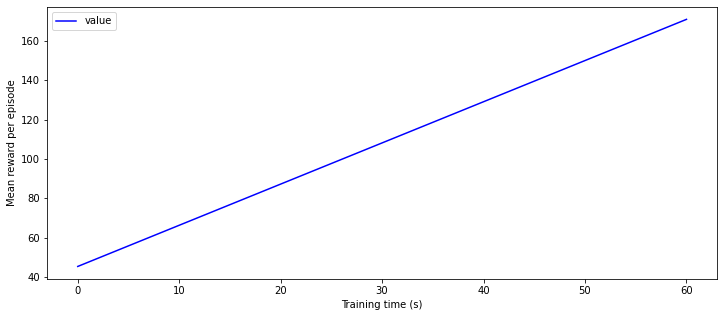

In [18]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

if not local_mode:
    df = TrainingJobAnalytics(job_name, ['episode_reward_mean']).dataframe()
    num_metrics = len(df)
    if num_metrics == 0:
        print("No algorithm metrics found in CloudWatch")
    else:
        plt = df.plot(x='timestamp', y='value', figsize=(12,5), legend=True, style='b-')
        plt.set_ylabel('Mean reward per episode')
        plt.set_xlabel('Training time (s)')
else:
    print("Can't plot metrics in local mode.")

### Monitor training progress
You can repeatedly run the visualization cells to get the latest videos or see the latest metrics as the training job proceeds.

## Evaluation of RL models

We use the last checkpointed model to run evaluation for the RL Agent. 

### Load checkpointed model

Checkpointed data from the previously trained models will be passed on for evaluation / inference in the checkpoint channel. In local mode, we can simply use the local directory, whereas in the SageMaker mode, it needs to be moved to S3 first.

In [19]:
if local_mode:
    model_tar_key = "{}/model.tar.gz".format(job_name)
else:
    model_tar_key = "{}/output/model.tar.gz".format(job_name)
    
local_checkpoint_dir = "{}/model".format(tmp_dir)

wait_for_s3_object(s3_bucket, model_tar_key, tmp_dir, training_job_name=job_name)  

if not os.path.isfile("{}/model.tar.gz".format(tmp_dir)):
    raise FileNotFoundError("File model.tar.gz not found")
    
os.system("mkdir -p {}".format(local_checkpoint_dir))
os.system("tar -xvzf {}/model.tar.gz -C {}".format(tmp_dir, local_checkpoint_dir))

print("Checkpoint directory {}".format(local_checkpoint_dir))

Waiting for s3://sagemaker-us-west-2-775004277940/rl-cartpole-ray-2021-03-25-00-23-32-232/output/model.tar.gz...
Checkpoint directory /tmp/rl-cartpole-ray-2021-03-25-00-23-32-232/model


In [20]:
if local_mode:
    checkpoint_path = 'file://{}'.format(local_checkpoint_dir)
    print("Local checkpoint file path: {}".format(local_checkpoint_dir))
else:
    checkpoint_path = "s3://{}/{}/checkpoint/".format(s3_bucket, job_name)
    if not os.listdir(local_checkpoint_dir):
        raise FileNotFoundError("Checkpoint files not found under the path")
    os.system("aws s3 cp --recursive {} {}".format(local_checkpoint_dir, checkpoint_path))
    print("S3 checkpoint file path: {}".format(checkpoint_path))

S3 checkpoint file path: s3://sagemaker-us-west-2-775004277940/rl-cartpole-ray-2021-03-25-00-23-32-232/checkpoint/


In [21]:
%%time
    
estimator_eval = RLEstimator(entry_point="evaluate-ray.py",
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        image_uri=image_name,
                        role=role,
                        instance_type=instance_type,
                        instance_count=1,
                        base_job_name=job_name_prefix + "-evaluation",
                        hyperparameters={
                            "evaluate_episodes": 10,
                            "algorithm": "PPO",
                            "env": "CartPole-v1"
                        }
                    )

estimator_eval.fit({'model': checkpoint_path})
job_name = estimator_eval.latest_training_job.job_name
print("Evaluation job: %s" % job_name)

2021-03-25 00:30:26 Starting - Starting the training job...
2021-03-25 00:30:49 Starting - Launching requested ML instancesProfilerReport-1616632226: InProgress
......
2021-03-25 00:31:49 Starting - Preparing the instances for training...
2021-03-25 00:32:21 Downloading - Downloading input data...
2021-03-25 00:32:49 Training - Downloading the training image.........
2021-03-25 00:34:28 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-03-25 00:34:29,446 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-03-25 00:34:29,450 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-03-25 00:34:29,461 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-03-25 00:34:32,494 sagemaker_pytorch_container.training INFO     Invoking user training script.
